<a href="https://colab.research.google.com/github/alchua1996/MachineLearning/blob/master/wavelet_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


Wavelets, in a more formal sense, are square integrable functions with zero average. Certain types of wavelets are useful because convolving a discreitzation of a wavelet with an image will allow us to discern features of an image, like edges and brightness. We can use this concept in image processing and machine learning to retrieve good features for image classification. 

In this notebook, we'll discuss how to implement a wavelet transform with a gabor wavelet and use the wavelet transform we've created to extract features from an image of a butterfly. 

# Import Libraries


In [32]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns
sns.set()

# Background Knowledge and Theory

A Gabor wavelet, which we'll call $\psi$, is a wavelet that can be written as
$$\psi(x) = e^{i \xi x} g(x)$$
and
$$g(x) = \frac{1}{2 \pi \sigma^2} e^{\frac{-|x|^2}{2}}.$$
Note that $x, \xi \in \mathbb{R}^2$. 

We define
$$\psi_{j,\theta} = 2^{-2j} \psi(2^{-j}R_\theta^{-1} x)$$
where $R \in SO(2)$ and $0 \leq \theta < \pi$.

To extract features from images, we'll convolve  $\psi_{j, \theta}$ with our image at a set number of scales and a set number of angles.


#Load Image

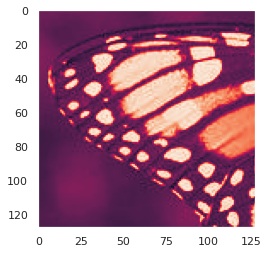

In [33]:
# Load image and crop to make 256x256
img_orig = mpimg.imread('/content/drive/My Drive/butterfly.jpg')
img = img_orig[44:172,44:172] / 255
plt.imshow(img)
plt.grid(False);

# Helper Functions


We'll first create some functions to help us in our goal. The rotations are represented by the following matrix:

In [35]:
def rot_inv(theta):
    mat = np.zeros((2,2))
    mat[0][0] = np.cos(-theta)
    mat[1][1] = mat[0][0]
    mat[0][1] = -np.sin(-theta)
    mat[1][0] = -mat[0][1]
    return mat

Next, we'll have to generate a filter bank containing all our Gabor wavelets for future use. Some variables will be defined for future use below.

Our inputs will be the following: 
*   $N$: The number of pixels for a side. 
*   $\sigma$: Width of the smallest wavelet.
*   $\xi$: Central Frequency of mother wavelet. 
*   $L$: Number of rotations with angle sampled on $[0, \pi)$ uniformly. 
*   $J$: Number of scales with $j = 0, \ldots, J-1$. 

Our output will be the following:  


*   $\Psi$: An $N\times N\times L\times J$ numpy array containing the wavelets in space. \\





In [36]:
def gabor_wavelets(N, sigma, xi, L, J):
    psi = np.zeros((N,N,L,J), dtype = 'complex')
    for n in range(N):
        for m in range(N):
            for k in range(L):
                for j in range(J): 
                     x = np.zeros(2, dtype = 'complex')
                     x[0] = (n-int(N/2)) / 2**j
                     x[1] = (m-int(N/2)) / 2**j
                     z = np.dot(rot_inv(np.pi * k / L), xi)
                     z = np.dot(z,x)
                     psi[n,m,k,j] = 2**(-2*j) * 1/(2 * np.pi * sigma**2) * np.exp(-np.dot(x,x) /(2* sigma**2)) * np.exp(1j * z)
    return psi

Let's generate our filter bank to check if it's correct.

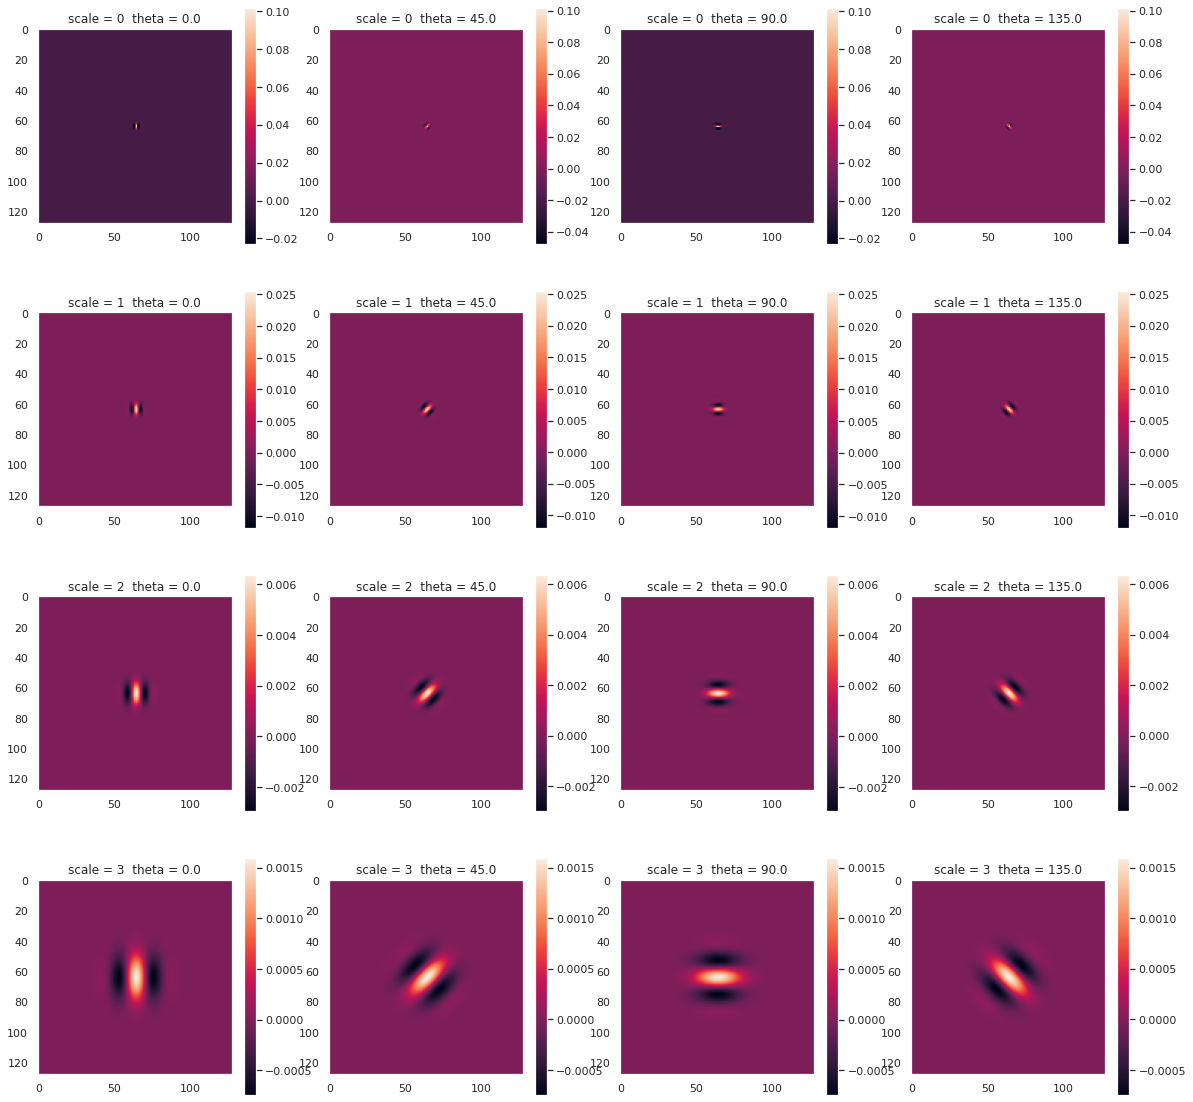

In [37]:
sigma = 1.25
xi = [0 , np.pi * 3/5]
num_scales = 4
num_angles = 4
filter_bank = gabor_wavelets(img.shape[0], sigma, xi, num_angles, num_scales)

c = 1
plt.figure(figsize = (5*num_scales,5*num_angles))
for j in range(num_scales):
    for l in range(num_angles):
        plt.subplot(num_scales,num_angles,c)
        plt.imshow(np.real(filter_bank[:,:,l,j]))
        plt.colorbar()
        plt.title('scale = ' + str(j) + ' ' + ' theta = ' + str(l/num_scales*180))
        plt.grid(False);
        c = c+1

Okay, now let's perform the wavelet transforms for each scale and frequency. We'll then print the output.

In [38]:
out = np.zeros_like(filter_bank)
for j in range(num_scales):
    for l in range(num_angles):
        out[:,:,l,j] = signal.convolve2d(img, filter_bank[:,:,l,j], mode = 'same')

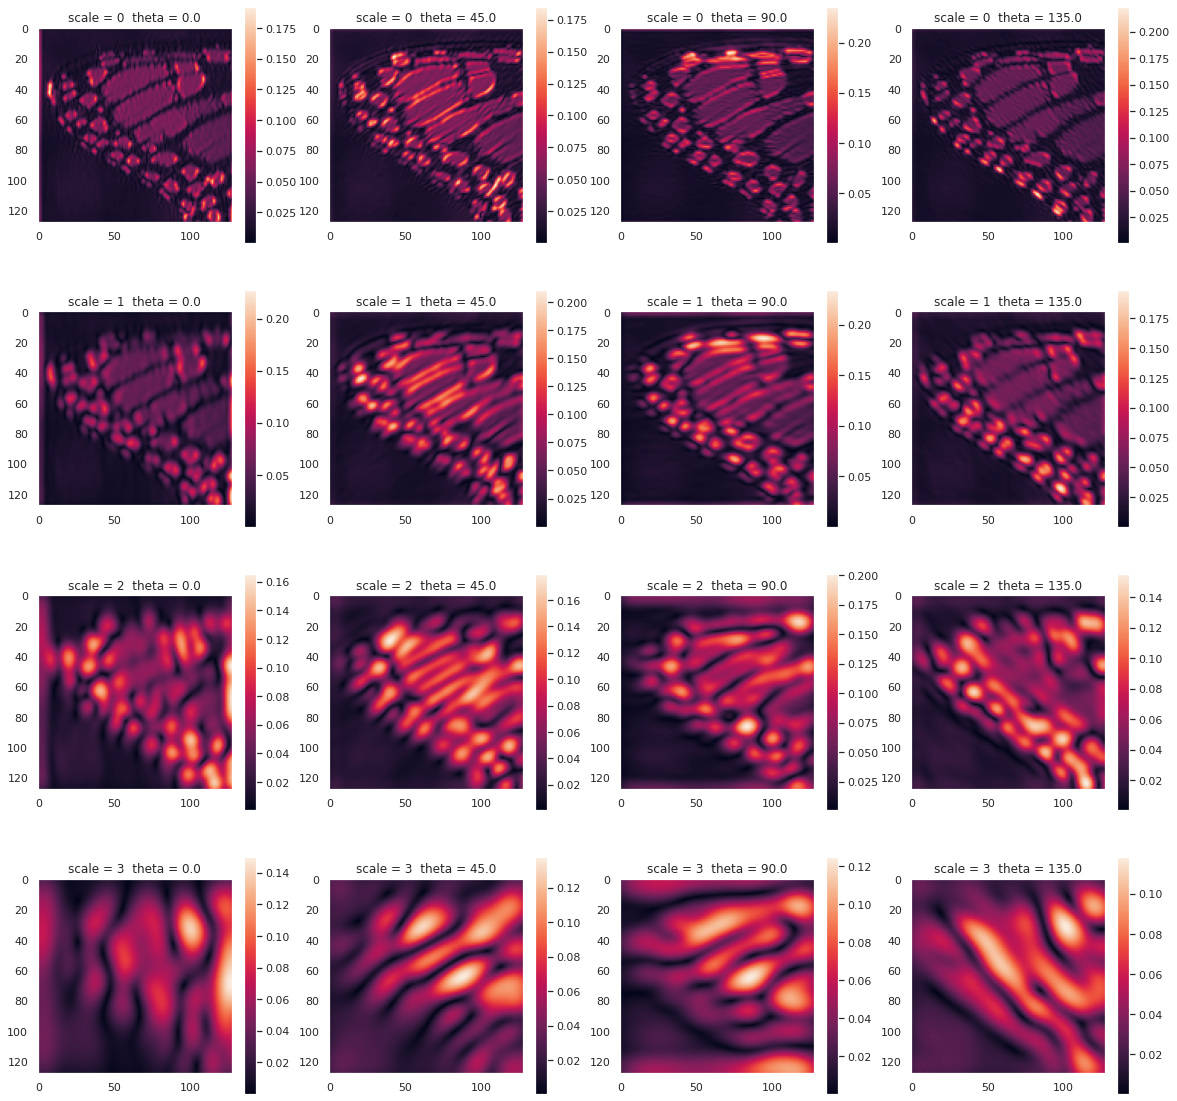

In [40]:
c = 1
plt.figure(figsize = (5*num_scales,5*num_angles))
for j in range(num_scales):
    for l in range(num_angles):
        plt.subplot(num_scales,num_angles,c)
        plt.imshow(np.abs(out[:,:,l,j]))
        plt.colorbar()
        plt.title('scale = ' + str(j) + ' ' + ' theta = ' + str(l/num_scales*180))
        plt.grid(False);
        c = c+1

#Discussion and Conclusions

This algorithm worked, but we can definitely make it faster. One way of approaching this problem is to calculate the fourier transform of the wavelet on paper and implement it. This is simple to calculate because of our specific wavelet.From here, we can find the FFT of the image. When we take the product, we apply the convolution theorem to get
$$\mathcal{F}(\psi_{j,\theta})\mathcal{F}({f}) = \mathcal{F}(f \ast \psi_{j,\theta}).$$
With an inverse fourier transform, we get the wavelet transform back.

This approach is cheaper from a computational standpoint since convolutions in space are $O(N^3)$ in our case, but an FFT or IFFT is at most $O(N^2 \log N)$.

For a future project, we would like to use this algorithm for machine learning applications. An interesting idea is to use this to extract features from CIFAR 10 and apply a Deep Neural Network for image classification. It's more computationally expensive than a CNN, but it's interesting to see what will happen.